# Regression for a single day, and modeling of another

## Importing

In [8]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import salishsea_tools.viz_tools as sa_vi

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.metrics import root_mean_squared_error as rmse


## Regressor

In [9]:
def regressor (inputs, targets, variable_name):

    # Pre processing 
    indx = np.where(~np.isnan(inputs).any(axis=0))
    inputs2 = inputs[:,indx[0]]
    inputs2 = inputs2.transpose()

    targets2 = np.ravel(targets)
    targets2 = targets2[indx[0]]

     # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs2)
    X_train, X_test, y_train, y_test = train_test_split(inputs2, targets2)

    regr0 = MLPRegressor()
    regr = BaggingRegressor(regr0, n_estimators=12, n_jobs=4).fit(X_train, y_train)

    outputs_test = regr.predict(X_test)
    outputs = regr.predict(inputs2)

    scatter_plot(y_test, outputs_test, variable_name + ' (Testing dataset)')

    # Post processing
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[0]] = outputs
    model = np.reshape(indx2,(898,398)) 

    # Preparation of the dataarray 
    model = xr.DataArray(model,
        coords = {'y': dataset.y, 'x': dataset.x},
        dims = ['y','x'],
        attrs=dict( long_name = variable_name + " Concentration",
        units="mmol m-2"))
                        
    plotting(targets2, model, targets, variable_name)

    return (regr)


## Printing

In [10]:
def printing (targets, outputs, m):

    print ('The slope of the best fitting line is ', np.round(m,3))
    print ('The correlation coefficient is:', np.round(np.corrcoef(targets, outputs)[0][1],3))
    print (' The root mean square error is:', rmse(targets,outputs))


## Scatter Plot

In [11]:
def scatter_plot(targets, outputs, variable_name):

    # compute slope m and intercept b
    m, b = np.polyfit(targets, outputs, deg=1)

    printing (targets, outputs, m)
    
    fig, ax = plt.subplots()

    plt.scatter(targets,outputs, alpha = 0.2, s = 10)
    plt.xlabel('targets')
    plt.ylabel('outputs')

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # plot fitted y = m*x + b
    plt.axline(xy1=(0, b), slope=m, color='r')

    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.plot(lims, lims,linestyle = '--',color = 'k')

    fig.suptitle(str(dataset.time_counter[0].dt.date.values) + ', ' + variable_name)

    plt.show()


## Plotting

In [12]:
def plotting (targets, model, variable, variable_name):

    fig, ax = plt.subplots(2,2, figsize = (10,15))

    cmap = plt.get_cmap('cubehelix')
    cmap.set_bad('gray')

    variable.plot(ax=ax[0,0], cmap=cmap, vmin = targets.min(), vmax =targets.max(), cbar_kwargs={'label': variable_name + ' Concentration  [mmol m-2]'})
    model.plot(ax=ax[0,1], cmap=cmap, vmin = targets.min(), vmax = targets.max(), cbar_kwargs={'label': variable_name + ' Concentration  [mmol m-2]'})
    ((variable-model) / variable * 100).plot(ax=ax[1,0], cmap=cmap, cbar_kwargs={'label': variable_name + ' Concentration  [percentage]'})

    plt.subplots_adjust(left=0.1,
        bottom=0.1, 
        right=0.95, 
        top=0.95, 
        wspace=0.35, 
        hspace=0.35)

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])

    ax[0,0].title.set_text(variable_name + ' (targets)')
    ax[0,1].title.set_text(variable_name + ' (outputs)')
    ax[1,0].title.set_text('targets - outputs')
    ax[1,1].axis('off')

    fig.suptitle(str(dataset.time_counter[0].dt.date.values))

    plt.show()
    

## Regressor for Other Days

In [13]:
def regressor2 (inputs,targets, variable_name, reg_variable):
    
    # Pre processing 
    indx = np.where(~np.isnan(inputs).any(axis=0))
    inputs2 = inputs[:,indx[0]]
    inputs2 = inputs2.transpose()

    targets2 = np.ravel(targets)
    targets2 = targets2[indx[0]]

    # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs2)
    outputs = reg_variable.predict(inputs2)

    # Post processing
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[0]] = outputs
    model = np.reshape(indx2,(898,398)) 
    
    scatter_plot(targets2,outputs,variable_name)

    # Preparation of the dataarray 
    model = xr.DataArray(model,
        coords = {'y': dataset.y, 'x': dataset.x},
        dims = ['y','x'],
        attrs=dict( long_name = variable_name + " Concentration",
        units="mmol m-2"))
                
    plotting(targets2, model, targets, variable_name)


## Training

The slope of the best fitting line is  0.881
The correlation coefficient is: 0.952
 The root mean square error is: 0.022160208


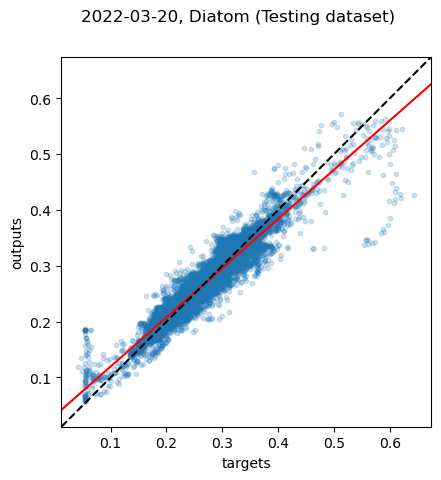

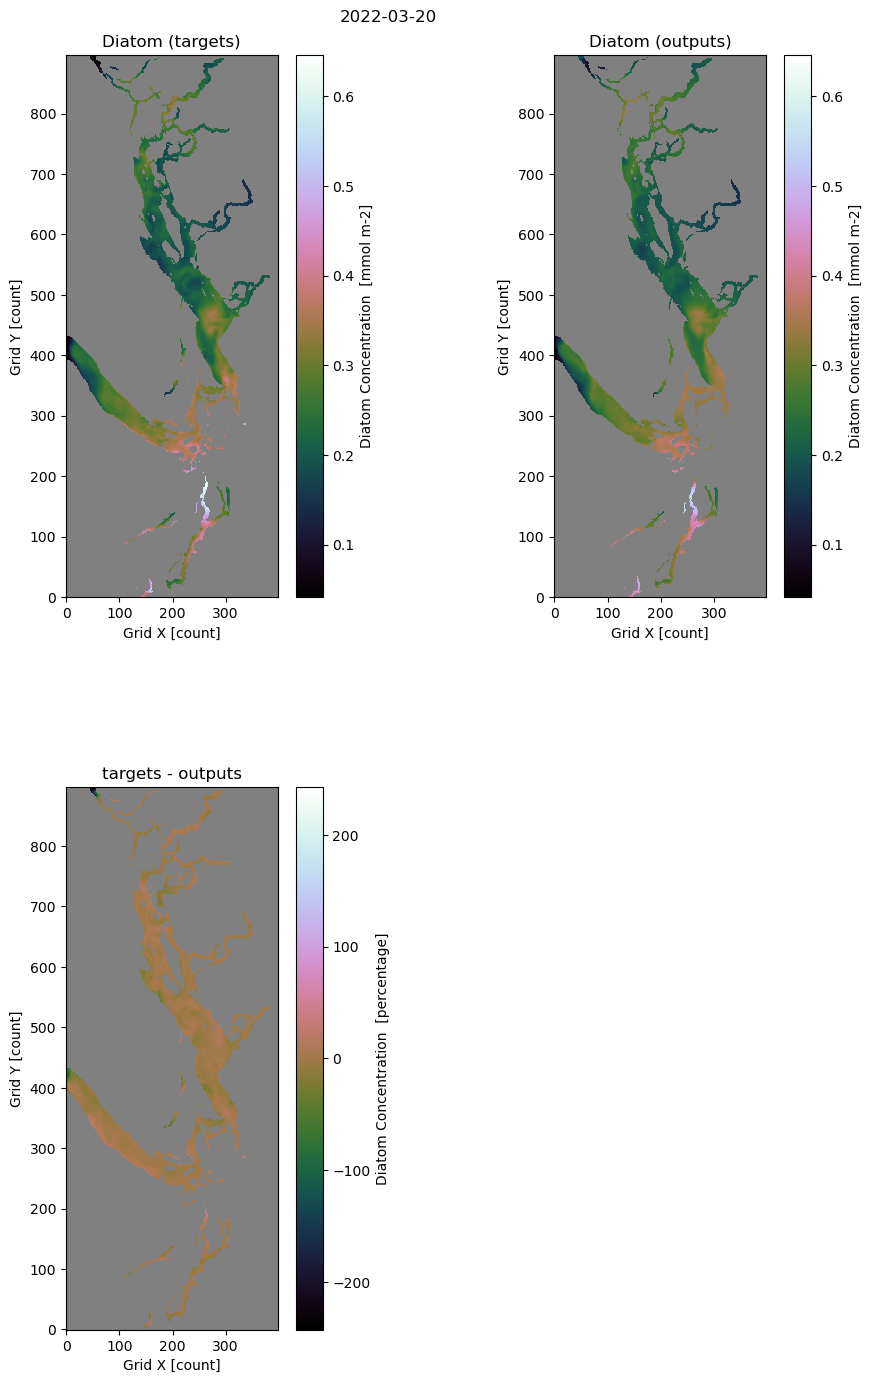

The slope of the best fitting line is  0.952
The correlation coefficient is: 0.982
 The root mean square error is: 0.003973947


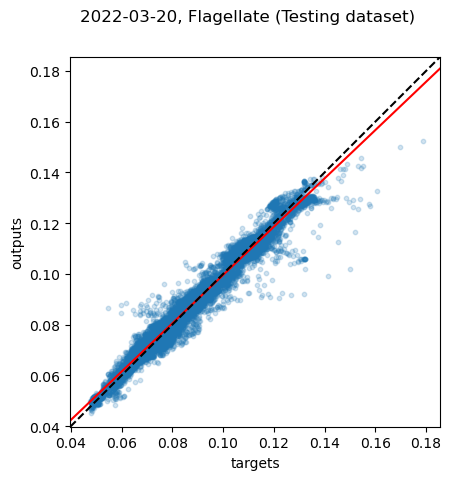

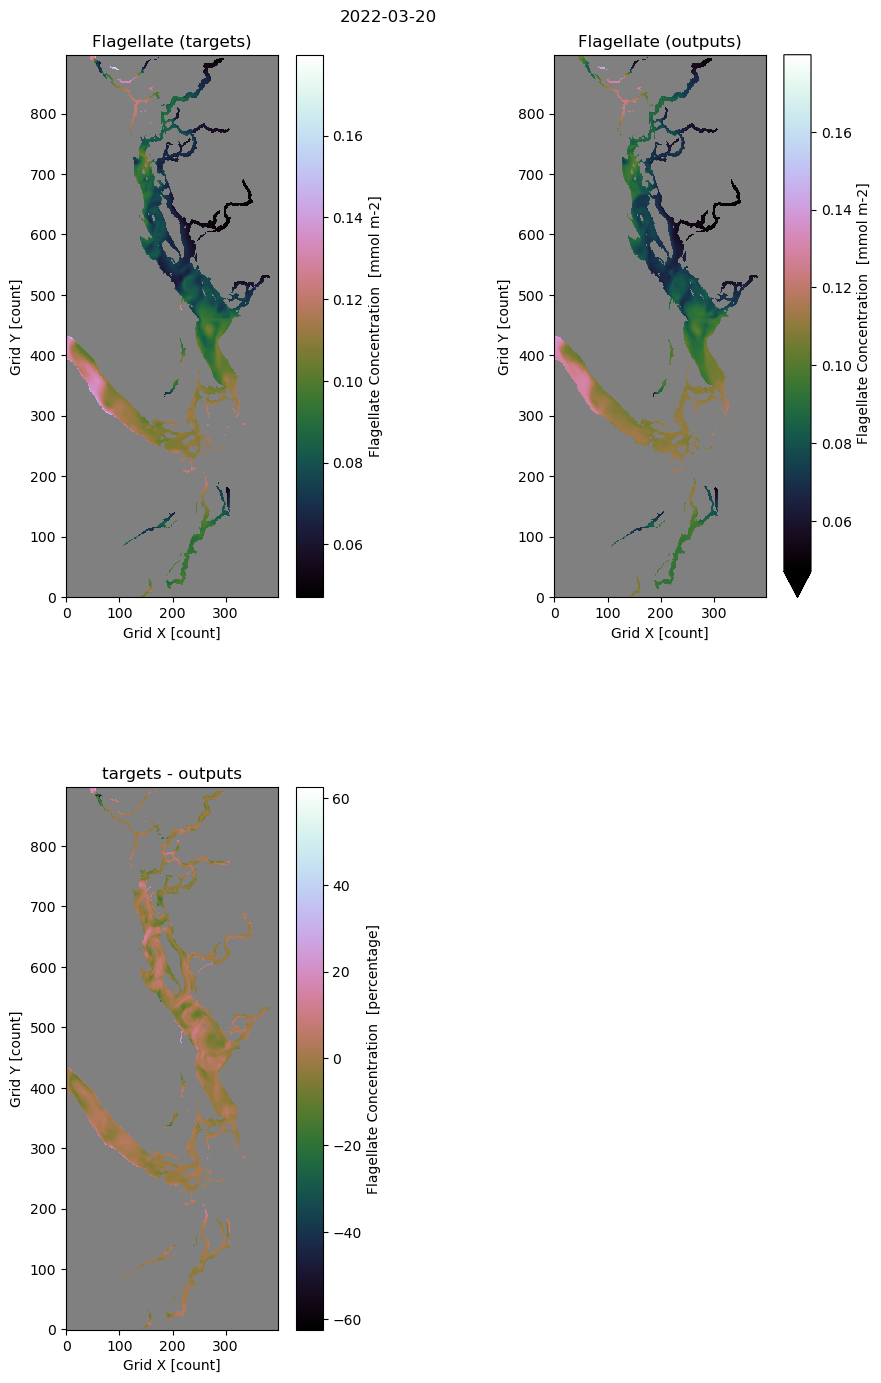

In [14]:
# Dataset and date
ds = xr.open_dataset('/data/ibougoudis/MOAD/files/integrated_original.nc')
                                          
dataset = ds.sel(time_counter='2022-03-20')                                          

# Potential input variables
drivers = np.stack([np.ravel(dataset['Temperature_(0m-15m)']),
    np.ravel(dataset['Temperature_(15m-100m)']), np.ravel(dataset['Salinity_(0m-15m)']),
    np.ravel(dataset['Salinity_(15m-100m)'])])
nutrients = np.stack([np.ravel(dataset['Silicon']), np.ravel(dataset['Nitrate']), 
    np.ravel(dataset['Ammonium'])])
phyto = np.stack([np.ravel(dataset['Diatom']), np.ravel(dataset['Flagellate'])])
zoo = np.stack([np.ravel(dataset['Microzooplankton']), 
    np.ravel(dataset['Mesozooplankton'])])

reg_diat = regressor(drivers, dataset['Diatom'], 'Diatom')
reg_flag = regressor(drivers, dataset['Flagellate'], 'Flagellate')


## Another Day

The slope of the best fitting line is  0.174
The correlation coefficient is: 0.295
 The root mean square error is: 0.19982556


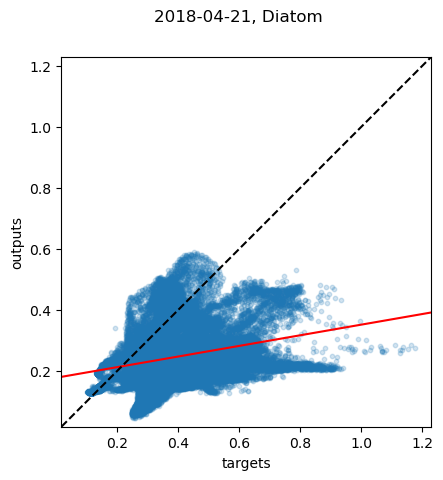

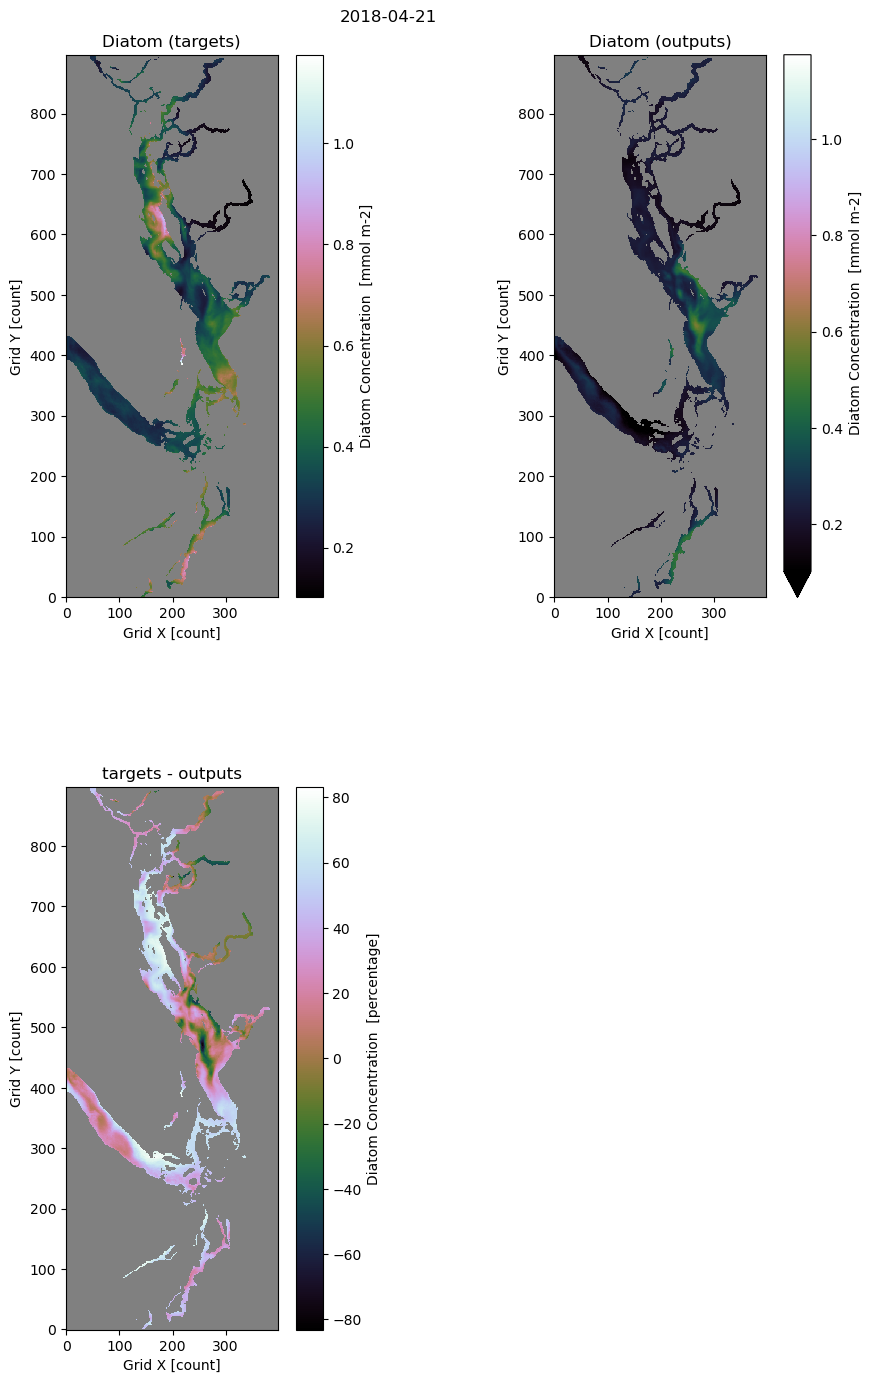

The slope of the best fitting line is  0.194
The correlation coefficient is: 0.163
 The root mean square error is: 0.021712415


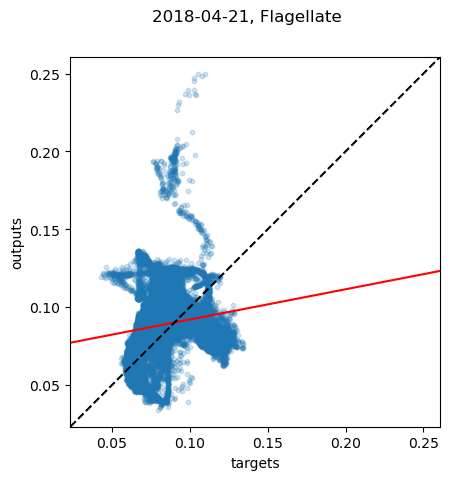

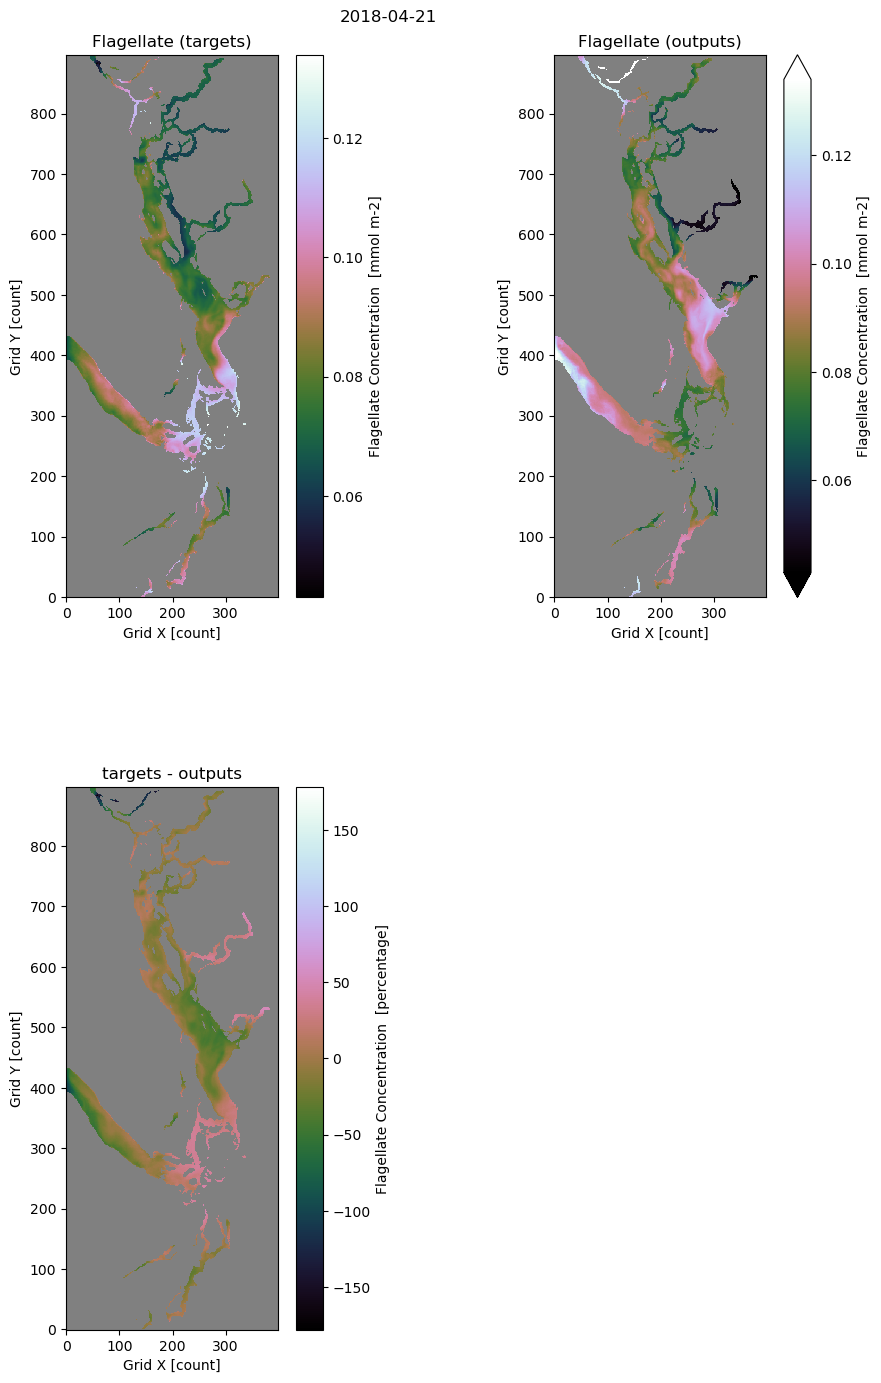

In [15]:
# Dataset and date
ds = xr.open_dataset('/data/ibougoudis/MOAD/files/integrated_original.nc')
date = pd.DatetimeIndex(ds['time_counter'].values)
                                          
dataset = ds.sel(time_counter='2018-04-21')                                          

# Potential input variables
drivers = np.stack([np.ravel(dataset['Temperature_(0m-15m)']),
    np.ravel(dataset['Temperature_(15m-100m)']), np.ravel(dataset['Salinity_(0m-15m)']),
    np.ravel(dataset['Salinity_(15m-100m)'])])
nutrients = np.stack([np.ravel(dataset['Silicon']), np.ravel(dataset['Nitrate']), 
    np.ravel(dataset['Ammonium'])])
phyto = np.stack([np.ravel(dataset['Diatom']), np.ravel(dataset['Flagellate'])])
zoo = np.stack([np.ravel(dataset['Microzooplankton']), 
    np.ravel(dataset['Mesozooplankton'])])

regressor2(drivers, dataset['Diatom'], 'Diatom', reg_diat)
regressor2(drivers, dataset['Flagellate'], 'Flagellate', reg_flag)
